# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model
            
**<h3> Sections:**
* [Importing Libraries](#Importing_Libraries)
* [Data Preparation](#Data_Preparation)
* [MediaPipe Implementation](#MediaPipe_Implementation)
* [Visualizing Landmarks](#Visualizing_Landmarks)
* [Data Encoding](#Data_Encoding)
* [Label Filtering](#Label_Filtering)
* [Data Loading](#Data_Loading)
* [Data Augmentation](#Data_Augmentation)
* [Data Preprocessing](#Data_Preprocessing)
* [Label Encoding](#Label_Encoding)
* [Models](#Models)
    
<h4> If you found this notebook helpful, an upvote would be appreciated!

---

<div id="Importing_Libraries">
    
# **Importing Libraries** 

In [3]:
!pip install -q mediapipe==0.10.7

In [4]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

<h3> We first load the data

In [5]:
with open('archive/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)

In [6]:
all_data=all_data[:100]

<h3> Then we extract the needed information from the data
<h4>    
    
* gloss : the word being expressed
    
* video_path : the path to the video in the datasets
    
* frame_start : the frame number where the word starts
    
* frame_end : the frame number where each word ends
   
* split : the type of data when modeling (train, val, test)

In [7]:
video_dir = 'archive/videos'
# backup_dir = '/kaggle/input/wlasl2000-resized/wlasl-complete/videos'
data = [] # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    for instance in instances:
        video_id = instance['video_id']
        if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
            video_path = os.path.join(video_dir, f'{video_id}.mp4')
        # elif os.path.exists(os.path.join(backup_dir, f'{video_id}.mp4')):
            # video_path = os.path.join(backup_dir, f'{video_id}.mp4')
        else:
            continue
            
        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1564.04it/s]


In [8]:
data


[{'gloss': 'book',
  'video_path': 'archive/videos\\69241.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07069.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07068.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07070.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07099.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07074.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\69302.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\65539.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss':

In [9]:
len(data)

1013

<h3> We then save the organized dictionary for future uses

In [10]:
with open('./WLASL_parsed_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)
    
FileLink(r'WLASL_parsed_data.json')

k:\sem 3\capstone\mute\WLASL_parsed_data.json

---

<div id="MediaPipe_Implementation">

# **MediaPipe Implementation**
**<h2>(Not important when training)**

<h3> We first choose the landmarks
<h4>    
    
* Hands : we'll keep all **42** of them, as they are the most important part.
    
* Pose : **6** landmarks for the upper body excluding the face, as we have dedicated process for it.
    
* Face : out of the **478** landmarks, we'll choose **132**, focusing on the lips, eyes, eyebrows, and the outline of the face.
    
* This brings the total number of landmarks to **180**, each with coordinates (x, y, z).   

In [11]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

<h3>Extracting landmarks from a frame

In [12]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

def get_frame_landmarks(frame):
    
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))
    
    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
        
    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
        
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)

    return all_landmarks

<h3>Extracting landmarks from a video

In [13]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    
    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    # if the video is precropped
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    # if the final frame was not given (-1)    
    if end_frame < 0: 
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    cap.release()
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

<h3>Drawing landmarks on a video

In [14]:
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

---

<div id="Visualizing_Landmarks">

# **Visualizing Landmarks**
**<h2>(Not important when training)**

<h3>Test on a frame

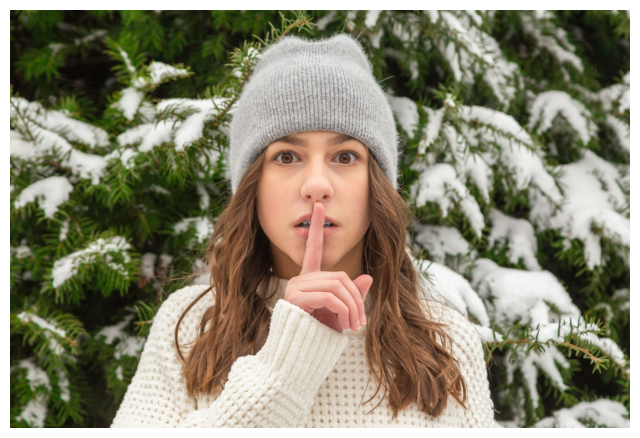

In [15]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://images.unsplash.com/photo-1610022069557-5f450d46cccd?q=80&w=2060&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

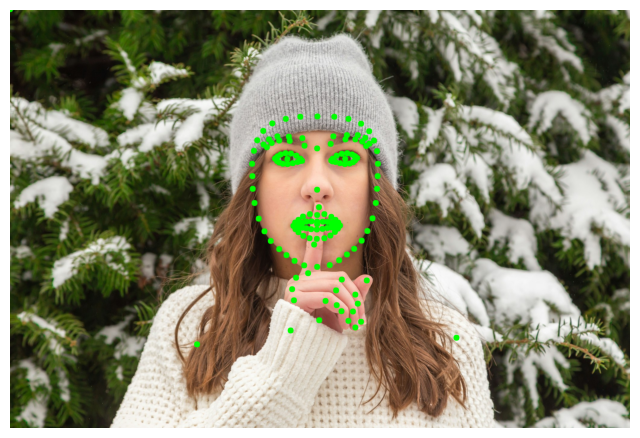

In [16]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

<h3> Test on video

In [17]:
with open('/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)
data=data[:100]  
test = data[40]
video_landmarks = get_video_landmarks(test['video_path'],test['frame_start'],test['frame_end'])

output_path = './landmarks_test.mp4'
draw_landmarks(test['video_path'], output_path, video_landmarks, test['frame_start'],test['frame_end'])

In [18]:
# os.remove('/kaggle/working/landmarks_test.mp4')

---

<div id="Data_Encoding">
    
# **Data Encoding**
**<h2>(Done Once)**

In [19]:
# npy_dir = './landmarks'
# os.makedirs(npy_dir, exist_ok=True)

In [30]:
data

[{'gloss': 'book',
  'video_path': 'archive/videos\\69241.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07069.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07068.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07070.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07099.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07074.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\69302.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\65539.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss':

In [20]:
# try:
#     for i in tqdm(range(len(data)), ncols=100):
#         npy_path = os.path.join(npy_dir, f'{i}.npy')
#         if os.path.exists(npy_path): continue
#         video_path = data[i]['video_path']
#         start = data[i]['frame_start']
#         end = data[i]['frame_end']
        
#         try:
#             video_landmarks = get_video_landmarks(video_path, start, end)
#             np.save(npy_path, video_landmarks)
            
#         except Exception as e:
#             print(f"\nError encoding {video_path}\n{e}")
#             continue   
#         clear_output(wait=True)

# except KeyboardInterrupt:
#     print("\nLoading process interrupted by user.")

In [31]:
npy_dir2 = './landmarks2'
os.makedirs(npy_dir2, exist_ok=True)

In [60]:
try:
    for i in tqdm(range(len(data)), ncols=100):
        print(i)
        npy_path = os.path.join(npy_dir2, f'{data[i]["gloss"]}.npy')
        if os.path.exists(npy_path): continue
        video_path = data[i]['video_path']
        start = data[i]['frame_start']
        end = data[i]['frame_end']
        
        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)
            
        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 15290.94it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [59]:
npy_dir2

'./landmarks2'

In [21]:
# npy_dir = './landmarks'


In [22]:
# landmarks_dict = {}

# for filename in os.listdir(npy_dir):
#     if filename.endswith('.npy'):
#         key = filename.split('.')[0]
#         landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
#         landmarks_dict[key] = landmarks

# np.savez_compressed('./landmarks_V2.npz', **landmarks_dict)

# FileLink(r'landmarks_V2.npz')

In [23]:
# shutil.rmtree(npy_dir)
# os.remove('/kaggle/working/landmarks_V2.npz')

---

<div id="Label_Filtering">

# **Label Filtering**
**<h2>(Done Once)**

In [24]:
# Upgrade pip
!python -m pip install --upgrade pip

# Install FastText
!pip install fasttext-wheel

In [230]:

# # Prepare X and Y
# X = []
# Y = []

# for i, entry in enumerate(data):
#     npy_path = f'./landmarks2/{data[i]["gloss"]}.npy'  # Assuming your .npy files are named 1.npy, 2.npy, etc.
#     Y.append(np.load(npy_path))  # Load .npy file
#     X.append(entry['gloss'])  # Extract the gloss as the label

# # Split the data into training and validation sets
# X_train = [X[i] for i in range(len(data)) if data[i]['split'] == 'train']
# Y_train = [Y[i] for i in range(len(data)) if data[i]['split'] == 'train']

# X_val = [X[i] for i in range(len(data)) if data[i]['split'] == 'val']
# Y_val = [Y[i] for i in range(len(data)) if data[i]['split'] == 'val']

# X_test = [X[i] for i in range(len(data)) if data[i]['split'] == 'test']
# Y_test = [Y[i] for i in range(len(data)) if data[i]['split'] == 'test']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [90]:
import os
import numpy as np

# Define the directory containing the .npy files
directory = './landmarks2'

# Initialize lists to store X and Y
X_list = []
Y_list = []

# Enumerate all files in the directory
for idx, filename in enumerate(os.listdir(directory)):
    if filename.endswith('.npy'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Load the .npy file
        data = np.load(file_path)
        
        # Assuming the file contains two arrays to be split into X and Y
        # Adjust this part according to how your data is structured
        # For example, if data contains [X, Y], use:
        # X, Y = data[0], data[1]
        
        # Here, assuming data contains two arrays concatenated along the first axis
        # Adjust the splitting point based on your specific data
        split_point = len(data) // 2
        X, Y = filename.split('.')[0], data[split_point:]
        
        # Append to the lists
        X_list.append(X)
        Y_list.append(Y)

# Convert lists to numpy arrays
X = X_list
Y = Y_list

print("X :",X)
print("Y :",Y)


In [91]:
len(X)

9

In [92]:
len(Y)

9

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [94]:
len(X_train)

5

In [95]:
len(Y_train)

5

In [47]:
X

['before',
 'book',
 'candy',
 'chair',
 'clothes',
 'computer',
 'drink',
 'go',
 'who']

In [48]:
X_train

['chair', 'who', 'clothes', 'candy', 'drink']

In [49]:
X_train = list(set(X_train))

print(X_train)

['chair', 'who', 'drink', 'candy', 'clothes']


In [50]:
Y

[array([[[ 4.56777275e-01,  6.02619886e-01, -1.43839529e-07],
         [ 4.38084215e-01,  5.74133277e-01, -1.40695460e-03],
         [ 4.27101940e-01,  5.37749529e-01, -4.43690643e-03],
         ...,
         [ 6.22951508e-01,  2.19434857e-01,  6.63504656e-03],
         [ 5.66734791e-01,  2.37031698e-01,  1.03149060e-02],
         [ 6.14543080e-01,  2.21025661e-01,  5.05713793e-03]],
 
        [[ 4.59504515e-01,  6.04817092e-01, -1.92601320e-07],
         [ 4.40399528e-01,  5.74967146e-01, -1.74523843e-03],
         [ 4.29134816e-01,  5.37945569e-01, -5.00810705e-03],
         ...,
         [ 6.22604787e-01,  2.19397560e-01,  6.51968177e-03],
         [ 5.66449463e-01,  2.37071589e-01,  1.01543274e-02],
         [ 6.14276946e-01,  2.21046805e-01,  4.93480312e-03]],
 
        [[ 4.64590937e-01,  6.04520977e-01, -2.17470884e-07],
         [ 4.46676791e-01,  5.73643446e-01, -1.04105857e-03],
         [ 4.36640263e-01,  5.36115706e-01, -3.81913804e-03],
         ...,
         [ 6.22298896e

In [51]:
Y_train

[array([[[ 3.76658648e-01,  7.04147041e-01,  2.31580799e-07],
         [ 4.22829330e-01,  7.27396965e-01, -1.09514990e-03],
         [ 4.55985278e-01,  7.52303481e-01, -9.16133262e-03],
         ...,
         [ 5.72634637e-01,  2.36027941e-01,  9.76983272e-03],
         [ 5.01033545e-01,  2.33926147e-01, -9.28391179e-04],
         [ 5.61201155e-01,  2.36033618e-01,  5.99044655e-03]],
 
        [[ 3.77814740e-01,  7.04506814e-01,  2.13707480e-07],
         [ 4.27094191e-01,  7.29309201e-01, -1.06337515e-03],
         [ 4.61976826e-01,  7.50810623e-01, -8.05546064e-03],
         ...,
         [ 5.73016524e-01,  2.36379579e-01,  9.71932989e-03],
         [ 5.01173675e-01,  2.33887076e-01, -1.00709917e-03],
         [ 5.61399400e-01,  2.36248419e-01,  5.93191013e-03]],
 
        [[ 3.79670888e-01,  7.05167234e-01,  2.27785762e-07],
         [ 4.29216564e-01,  7.29980826e-01, -2.34623859e-03],
         [ 4.66273844e-01,  7.51483440e-01, -9.83445812e-03],
         ...,
         [ 5.73346019e

In [52]:
import fasttext
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')
# ft = fasttext.load_model('cc.en.300.bin')

In [53]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
len(data)

100

In [ ]:
labels = list(np.unique(Y_train))
len(labels)

9

In [ ]:
encoded_labels = {label: ft.get_word_vector(label) for label in labels}
np.savez_compressed('./labels.npz', **encoded_labels)

In [ ]:
ft.get_nearest_neighbors('happy', k=10)

[(0.7490978837013245, 'happpy'),
 (0.7035641670227051, 'hapy'),
 (0.6981647610664368, 'happier'),
 (0.6979567408561707, 'pleased'),
 (0.6735867857933044, 'glad'),
 (0.6564764976501465, 'satisfied'),
 (0.6552473306655884, 'super-happy'),
 (0.6515629291534424, 'unhappy'),
 (0.6506146788597107, 'thrilled'),
 (0.6238874197006226, 'overjoyed')]

In [ ]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

word1 = 'happy'
word2 = 'pleased'

vector1 = ft.get_word_vector(word1)
vector2 = ft.get_word_vector(word2)

similarity_score = cosine_similarity(vector1, vector2)
print(f"Similarity score between '{word1}' and '{word2}': {similarity_score}")

Similarity score between 'happy' and 'pleased': 0.6979568600654602


In [ ]:
labels_dict = np.load('./labels.npz', allow_pickle=True)

In [ ]:
word = 'car'
word_vector = ft.get_word_vector(word)

similarity_scores = []
for label, label_vector in labels_dict.items():
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

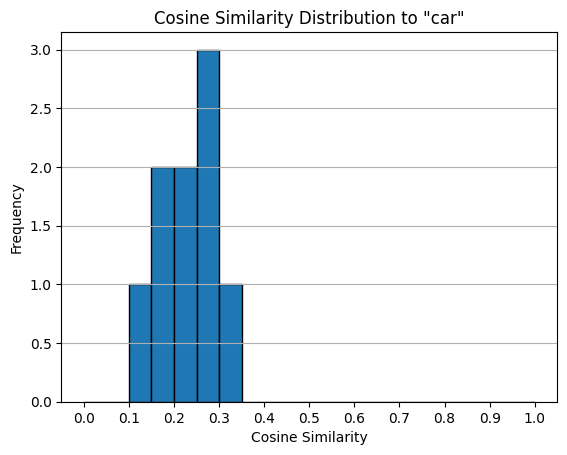

In [ ]:
bins = np.linspace(0, 1, 21)

plt.hist(similarity_scores, bins=bins, edgecolor='black')
plt.title(f'Cosine Similarity Distribution to "{word}"')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

In [ ]:
taxi_words = [
    'hello',
    'goodbye',
    'thank you',
    'sorry',
    'yes',
    'no',
    'stop',
    'go',
    'left',
    'right',
    'ahead',
    'around',
    'help',
    'address',
    'destination',
    'time',
    'money',
    'cost',
    'lost',
    'map',
    'street',
    'road'
]

In [ ]:
threshold = 0.4
similar_words_set = set()
taxi_vectors = [ft.get_word_vector(word) for word in taxi_words]

for label, label_vector in labels_dict.items():
    for taxi_vector in taxi_vectors:
        similarity_score = cosine_similarity(taxi_vector, label_vector)
        if similarity_score > threshold:
            similar_words_set.add(label)
            
similar_words_list = list(similar_words_set)

In [ ]:
similar_words_list

['go', 'before']

In [ ]:
len(similar_words_list)

2

In [ ]:
with open('./filtered_labels.txt', 'w') as file:
    for label in similar_words_list:
        file.write(label + '\n')

---

<div id="Data_Loading">
    
# **Data Loading**

In [ ]:
landmarks_dict = np.load('./landmarks_V2.npz', allow_pickle=True)

In [ ]:
len(landmarks_dict)

11980

In [ ]:
landmarks_dict

NpzFile './landmarks_V2.npz' with keys: 0, 1, 10, 100, 1000...

In [ ]:
labels_dict = np.load('./labels.npz', allow_pickle=True)

In [ ]:
len(labels_dict)

9

In [104]:
with open('./WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)
    


In [105]:
data=data[:100]

In [106]:
data

[{'gloss': 'book',
  'video_path': 'archive/videos\\69241.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07069.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07068.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07070.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07099.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'book',
  'video_path': 'archive/videos\\07074.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\69302.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'val'},
 {'gloss': 'drink',
  'video_path': 'archive/videos\\65539.mp4',
  'frame_start': 1,
  'frame_end': -1,
  'split': 'train'},
 {'gloss':

In [107]:
len(data)

100

In [ ]:
len(labels)

9

<h3> Filter Landmarks (Only for V3)

In [ ]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [ ]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 48, 52, 55, 56, 58, 61, 62, 65, 69, 81, 85, 87, 88, 94, 100, 101, 102, 103, 106, 109, 111, 113, 114, 115, 118, 126, 128, 129, 130, 132, 135, 136, 139, 141, 143, 151, 153, 155, 157, 175, 180, 181, 184, 192, 193, 194, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 220, 221, 224, 226, 229, 233, 239, 282, 294, 297, 299, 311, 315, 317, 318, 324, 330, 331, 332, 333, 336, 339, 341, 343, 344, 345, 348, 356, 358, 359, 360, 362, 365, 366, 369, 371, 372, 380, 382, 384, 386, 404, 409, 410, 413, 421, 422, 423, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 445, 446, 448, 450, 453, 457, 463, 502, 514, 516, 521]

Total Number: 180


<h3> Filter Data Source

In [ ]:
# Only from the wlasl-processed dataset
# keys = [k for k in landmarks_dict.keys() if 'wlasl-processed' in data[int(k)]['video_path']]

# Only from the wlasl2000-resized dataset
# keys = [k for k in landmarks_dict.keys() if 'wlasl2000-resized' in data[int(k)]['video_path']]

<h3> Filter Labels

In [ ]:
labels = []
with open('./filtered_labels.txt', 'r') as file:
    labels = file.read().splitlines()

In [ ]:
landmarks

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 53,
 54,
 55,
 56,
 57,
 58,
 48,
 52,
 55,
 56,
 58,
 61,
 62,
 65,
 69,
 81,
 85,
 87,
 88,
 94,
 100,
 101,
 102,
 103,
 106,
 109,
 111,
 113,
 114,
 115,
 118,
 126,
 128,
 129,
 130,
 132,
 135,
 136,
 139,
 141,
 143,
 151,
 153,
 155,
 157,
 175,
 180,
 181,
 184,
 192,
 193,
 194,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 220,
 221,
 224,
 226,
 229,
 233,
 239,
 282,
 294,
 297,
 299,
 311,
 315,
 317,
 318,
 324,
 330,
 331,
 332,
 333,
 336,
 339,
 341,
 343,
 344,
 345,
 348,
 356,
 358,
 359,
 360,
 362,
 365,
 366,
 369,
 371,
 372,
 380,
 382,
 384,
 386,
 404,
 409,
 410,
 413,
 421,
 422,
 423,
 425,
 426,
 427,
 428,
 429,
 430,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 445,
 446,
 448,
 450,
 453,
 457,
 463,
 502,
 514,
 516

In [ ]:
len(landmarks)

180

In [ ]:
len(labels)

2

<h3> Loading Function

In [ ]:
def load_data(split, labels=None, max_labels=None, max_samples=None, landmarks=None, keys=None):
    
    if landmarks is None:
        landmarks = list(range(landmarks_dict['0'].shape[1]))
    
    if keys is None:
        keys = [k for k in landmarks_dict.keys()]
    
    if labels is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
    
    elif max_samples is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
    
    elif max_labels is not None:
        label_counts = {}
        for k in keys:
            label = data[int(k)]['gloss']
            label_counts[label] = label_counts.get(label, 0) + 1
        
        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        
    else:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split]
    
    return X, Y

In [ ]:
len(X_train)

NameError: name 'X_train' is not defined

In [ ]:
X_train, Y_train = load_data('train', landmarks=landmarks, labels=labels)
X_val, Y_val = load_data('val', landmarks=landmarks, labels=labels)
X_test, Y_test = load_data('test', landmarks=landmarks, labels=labels)

IndexError: index 180 is out of bounds for axis 1 with size 180

In [ ]:
len(X_train), len(X_val)

(74, 18)

In [ ]:
X_train[0].shape

(75, 180, 3)

In [ ]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(9, 8, 6)

In [ ]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [ ]:
# free space
del landmarks_dict, data
gc.collect()

5311

---

<div id="Data_Augmentation">
    
# **Data Augmentation**

<h3> Rotation Augmentations

In [ ]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

<h3> Other Augmentations

In [ ]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

<h3> Apply Augmentations

In [ ]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [ ]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [ ]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|██████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 165.45it/s]


In [ ]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(148, 75, 180, 3)

In [ ]:
# free space
gc.collect()

9

<h3> Data Permutation

In [ ]:
permutation_train = list(range(len(Y_train)))
np.random.shuffle(permutation_train)
X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

permutation_val = list(range(len(Y_val)))
np.random.shuffle(permutation_val)
X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

permutation_test = list(range(len(Y_test)))
np.random.shuffle(permutation_test)
X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

<h3> Test Augmentation (Not necessary when training)

In [ ]:
frame_landmarks = np.expand_dims(frame_landmarks, axis=0)

In [ ]:
frame_landmarks.shape

(1, 180, 3)

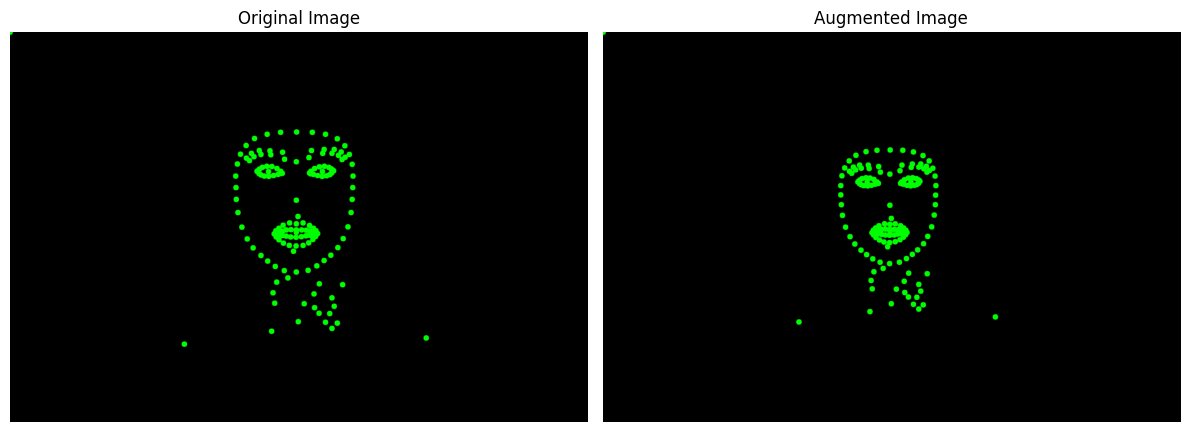

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

for landmark in frame_landmarks[0]:
    x = int(landmark[0] * img.shape[1])
    y = int(landmark[1] * img.shape[0])
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)
    
axs[0].set_title('Original Image')
axs[0].imshow(img[:, :, ::-1])
axs[0].axis('off')

augmented_landmarks = apply_augmentations(frame_landmarks.copy())
img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

for landmark in augmented_landmarks[0]:
    x = int(landmark[0] * img.shape[1])
    y = int(landmark[1] * img.shape[0])
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

axs[1].set_title('Augmented Image')
axs[1].imshow(img[:, :, ::-1])
axs[1].axis('off')

plt.tight_layout()
plt.show()

---

<div id="Data_Preprocessing">
    
# **Data Preprocessing**

<h3>
    
**Method 1:** Sequencing

In [ ]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [ ]:
X_train, Y_train = sequences(X_train, Y_train, length=60, step=20, pad=-100)
X_val, Y_val = sequences(X_val, Y_val, length=60, step=20, pad=-100)
X_test, Y_test = sequences(X_test, Y_test, length=60, step=20, pad=-100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((200, 60, 180, 3), (26, 60, 180, 3), (13, 60, 180, 3))

<h3>
    
**Method 2:** Padding

In [ ]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
#     Y = np.array(Y)
    return X_padded, Y

In [ ]:
X_train, Y_train = padding(X_train, Y_train, length=200, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=200, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=200, pad=-100)

MemoryError: Unable to allocate 18.8 GiB for an array with shape (23335, 200, 180, 3) and data type float64

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((5540, 200, 180, 3), (748, 200, 180, 3), (560, 200, 180, 3))

<h3>
    
**Method 3:** Skipping & Cloning

In [ ]:
def skipping(landmarks, desired_frames,mode='floor'):
    frames_num = landmarks.shape[0]
    if mode == 'floor':
        skip_factor = math.floor(frames_num / desired_frames)
    elif mode == 'ceil':
        skip_factor = math.ceil(frames_num / desired_frames)
    skipped_landmarks = []

    for i in range(0, frames_num, skip_factor):
        skipped_landmarks.append(landmarks[i])
        if len(skipped_landmarks)==desired_frames:
            break

    return np.array(skipped_landmarks)

# Test
skip_test = np.zeros((90, 180, 3))
result_1 = skipping(skip_test, 60)
result_2 = skipping(skip_test, 60,'ceil')
print(result_1.shape)
print(result_2.shape)   

NameError: name 'math' is not defined

In [ ]:
def cloning(landmarks, desired_frames):
    
    frames_num = landmarks.shape[0]
    repeat_factor = math.ceil(desired_frames / frames_num)
    
    cloned_list = np.repeat(landmarks, repeat_factor, axis=0)
    cloned_list = cloned_list[:desired_frames]
    return cloned_list

# Test
clone_test = np.random.random((29, 180, 3)) 
result = cloning(clone_test, 60)
print(result.shape)

In [ ]:
def clone_skip(landmarks_array,desired_frames):
    reshaped_landmarks = []
    for landmarks in landmarks_array:
        frames_number = landmarks.shape[0]
        
        if frames_number == desired_frames:
            reshaped_landmarks.append(landmarks)
        elif frames_number < desired_frames:
            reshaped_landmarks.append(cloning(landmarks,desired_frames))
        elif frames_number > desired_frames:
            reshaped_landmarks.append(skipping(landmarks,desired_frames))
    return np.array(reshaped_landmarks)

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [ ]:
# label_encoder = LabelEncoder()

# Y_train = label_encoder.fit_transform(Y_train)
# Y_val = label_encoder.fit_transform(Y_val)
# Y_test = label_encoder.fit_transform(Y_test)

In [ ]:
Y_train = np.array([labels_dict[label] for label in Y_train])
Y_val = np.array([labels_dict[label] for label in Y_val])
Y_test = np.array([labels_dict[label] for label in Y_test])

In [ ]:
Y_train.shape

(200, 300)

In [ ]:
# free space
gc.collect()

847

---

<div id="Models">
    
# **Models**

<h2>Hady's Model

In [10]:
X_train

['chair', 'who', 'drink', 'candy', 'clothes']

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on X_train_words and transform X_train_words
X_train_tfidf = vectorizer.fit_transform(X_train)

# Convert sparse matrix to dense array (if needed)
X_train = X_train_tfidf.toarray()

print("Original words:", X_train)
print("TF-IDF encoded X_train:")

Original words: [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
TF-IDF encoded X_train:


In [55]:
Y_train

[array([[[ 3.76658648e-01,  7.04147041e-01,  2.31580799e-07],
         [ 4.22829330e-01,  7.27396965e-01, -1.09514990e-03],
         [ 4.55985278e-01,  7.52303481e-01, -9.16133262e-03],
         ...,
         [ 5.72634637e-01,  2.36027941e-01,  9.76983272e-03],
         [ 5.01033545e-01,  2.33926147e-01, -9.28391179e-04],
         [ 5.61201155e-01,  2.36033618e-01,  5.99044655e-03]],
 
        [[ 3.77814740e-01,  7.04506814e-01,  2.13707480e-07],
         [ 4.27094191e-01,  7.29309201e-01, -1.06337515e-03],
         [ 4.61976826e-01,  7.50810623e-01, -8.05546064e-03],
         ...,
         [ 5.73016524e-01,  2.36379579e-01,  9.71932989e-03],
         [ 5.01173675e-01,  2.33887076e-01, -1.00709917e-03],
         [ 5.61399400e-01,  2.36248419e-01,  5.93191013e-03]],
 
        [[ 3.79670888e-01,  7.05167234e-01,  2.27785762e-07],
         [ 4.29216564e-01,  7.29980826e-01, -2.34623859e-03],
         [ 4.66273844e-01,  7.51483440e-01, -9.83445812e-03],
         ...,
         [ 5.73346019e

In [38]:
Y_train


array([[[ 3.76658648e-01,  7.04147041e-01,  2.31580799e-07],
        [ 4.22829330e-01,  7.27396965e-01, -1.09514990e-03],
        [ 4.55985278e-01,  7.52303481e-01, -9.16133262e-03],
        ...,
        [ 5.72634637e-01,  2.36027941e-01,  9.76983272e-03],
        [ 5.01033545e-01,  2.33926147e-01, -9.28391179e-04],
        [ 5.61201155e-01,  2.36033618e-01,  5.99044655e-03]],

       [[ 3.77814740e-01,  7.04506814e-01,  2.13707480e-07],
        [ 4.27094191e-01,  7.29309201e-01, -1.06337515e-03],
        [ 4.61976826e-01,  7.50810623e-01, -8.05546064e-03],
        ...,
        [ 5.73016524e-01,  2.36379579e-01,  9.71932989e-03],
        [ 5.01173675e-01,  2.33887076e-01, -1.00709917e-03],
        [ 5.61399400e-01,  2.36248419e-01,  5.93191013e-03]],

       [[ 3.79670888e-01,  7.05167234e-01,  2.27785762e-07],
        [ 4.29216564e-01,  7.29980826e-01, -2.34623859e-03],
        [ 4.66273844e-01,  7.51483440e-01, -9.83445812e-03],
        ...,
        [ 5.73346019e-01,  2.36285195e-01,

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reshape X_train to shape (n_samples, 1) as expected by OneHotEncoder
X_train_reshaped = np.array(X_train).reshape(-1, 1)

# Fit and transform the data
X_train = encoder.fit_transform(X_train_reshaped)


Y_train = np.concatenate(Y_train, axis=0)


In [62]:
len(Y_train)

5

In [59]:
X_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [75]:
len(Y_train)

4

In [61]:
Y_train

[array([[[ 3.76658648e-01,  7.04147041e-01,  2.31580799e-07],
         [ 4.22829330e-01,  7.27396965e-01, -1.09514990e-03],
         [ 4.55985278e-01,  7.52303481e-01, -9.16133262e-03],
         ...,
         [ 5.72634637e-01,  2.36027941e-01,  9.76983272e-03],
         [ 5.01033545e-01,  2.33926147e-01, -9.28391179e-04],
         [ 5.61201155e-01,  2.36033618e-01,  5.99044655e-03]],
 
        [[ 3.77814740e-01,  7.04506814e-01,  2.13707480e-07],
         [ 4.27094191e-01,  7.29309201e-01, -1.06337515e-03],
         [ 4.61976826e-01,  7.50810623e-01, -8.05546064e-03],
         ...,
         [ 5.73016524e-01,  2.36379579e-01,  9.71932989e-03],
         [ 5.01173675e-01,  2.33887076e-01, -1.00709917e-03],
         [ 5.61399400e-01,  2.36248419e-01,  5.93191013e-03]],
 
        [[ 3.79670888e-01,  7.05167234e-01,  2.27785762e-07],
         [ 4.29216564e-01,  7.29980826e-01, -2.34623859e-03],
         [ 4.66273844e-01,  7.51483440e-01, -9.83445812e-03],
         ...,
         [ 5.73346019e

In [19]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reshape X_train to shape (n_samples, 1) as expected by OneHotEncoder
X_val_reshaped = np.array(X_val).reshape(-1, 1)

# Fit and transform the data
X_val = encoder.fit_transform(X_val_reshaped)

Y_val = np.concatenate(Y_val, axis=0)





In [29]:
X_test_reshaped = np.array(X_test).reshape(-1, 1)

# Fit and transform the data
X_test = encoder.fit_transform(X_test_reshaped)

Y_test = np.concatenate(Y_test, axis=0)

In [30]:
X_test

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [31]:
Y_test

array([[[ 2.90001065e-01,  6.44099236e-01, -6.38664943e-08],
        [ 3.09967220e-01,  6.49578452e-01, -2.24968735e-02],
        [ 3.19700658e-01,  6.50300741e-01, -4.00081277e-02],
        ...,
        [ 5.46478450e-01,  2.37561211e-01,  1.97429792e-03],
        [ 4.79268551e-01,  2.36400813e-01,  3.85584566e-03],
        [ 5.36450446e-01,  2.38954902e-01,  3.06788279e-05]],

       [[ 2.94619024e-01,  6.44540012e-01, -5.67120431e-08],
        [ 3.13909769e-01,  6.49276495e-01, -2.23119985e-02],
        [ 3.22069526e-01,  6.49357557e-01, -3.77112329e-02],
        ...,
        [ 5.46234667e-01,  2.38259107e-01,  2.01330706e-03],
        [ 4.79153425e-01,  2.36622304e-01,  3.67614604e-03],
        [ 5.36325634e-01,  2.39437655e-01,  4.92522413e-05]],

       [[ 2.96715140e-01,  6.49681866e-01,  2.54139092e-08],
        [ 3.16829383e-01,  6.50997996e-01, -2.15102807e-02],
        [ 3.25546443e-01,  6.49487734e-01, -3.62086594e-02],
        ...,
        [ 5.46222806e-01,  2.38453820e-01,

In [20]:
X_val

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [88]:
len(Y_train)

4

In [73]:
Y_train

[array([[[ 4.47572261e-01,  5.30275285e-01,  1.55895549e-07],
         [ 4.68339503e-01,  5.05302429e-01, -4.06790758e-03],
         [ 4.84079808e-01,  4.57145333e-01, -6.16496196e-03],
         ...,
         [ 5.51770866e-01,  2.35723019e-01,  6.79599412e-04],
         [ 4.88834500e-01,  2.47630075e-01,  4.18805098e-03],
         [ 5.42723656e-01,  2.39713028e-01, -8.65701120e-04]],
 
        [[ 4.47395265e-01,  5.29928982e-01,  1.60551537e-07],
         [ 4.68067199e-01,  5.04940808e-01, -4.36778599e-03],
         [ 4.83960867e-01,  4.56871927e-01, -6.71923161e-03],
         ...,
         [ 5.51911354e-01,  2.36283362e-01,  5.52451413e-04],
         [ 4.88826245e-01,  2.47833416e-01,  4.15962143e-03],
         [ 5.42787910e-01,  2.39911526e-01, -9.79900360e-04]],
 
        [[ 4.47425306e-01,  5.29919922e-01,  1.64196479e-07],
         [ 4.67942357e-01,  5.04988432e-01, -4.46240092e-03],
         [ 4.83766973e-01,  4.57184881e-01, -6.96112262e-03],
         ...,
         [ 5.51866531e

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(180 * 3, activation='linear')  # Adjusted output layer for regression
])

# Reshape Y_train for compatibility with mean_squared_error loss function
Y_train_flattened = Y_train.reshape(-1, 180 * 3)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model (assuming you have a separate test set)
# Replace X_test and Y_test with your actual test data
# Y_test_flattened = Y_test.reshape(-1, 180 * 3)

# print(Y_test_flattened.shape)
# print(X_test.shape)


# loss = model.evaluate(X_test, Y_test_flattened)
# print(f"Test Loss: {loss}")


AttributeError: 'list' object has no attribute 'reshape'

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Example X_train
X_train_words = ['chair', 'who', 'drink', 'candy', 'clothes']

# Example Y_train, assuming it's already loaded as per your previous data
# Replace this with your actual Y_train data loading code
Y_train = Y_train

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on X_train_words and transform X_train_words
X_train_tfidf = vectorizer.fit_transform(X_train_words)

# Convert sparse matrix to dense array (if needed)
X_train_tfidf_array = X_train_tfidf.toarray()

# Splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train_tfidf_array, Y_train, test_size=0.2, random_state=42)

# Flatten Y_train and Y_test to match model output
# Y_train_flattened = Y_train.reshape(Y_train.shape[0], -1)  # Flatten along the last two dimensions
# Y_test_flattened = Y_test.reshape(Y_test.shape[0], -1)  # Flatten along the last two dimensions

# Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(Y_train.shape[1], activation='linear')  # Adjusted output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")


c:\Users\kuria\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'list' object has no attribute 'shape'

In [24]:
history

In [215]:
X_val.shape

(2, 2)

In [228]:
len(Y_val)

30780

In [225]:
Y_val = np.concatenate(Y_val, axis=0)


In [226]:
Y_val

array([3.56589645e-01, 4.61420536e-01, 1.89211818e-07, ...,
       6.10776305e-01, 2.20318392e-01, 4.57241898e-03])

In [25]:
from sklearn.metrics import mean_squared_error

# Assuming X_test and Y_test are your test sets
# Evaluate the model on test set
Y_pred = model.predict(X_val)

# Reshape Y_test and Y_pred to original shape
Y_test_original = Y_val.reshape(Y_pred.shape)
Y_pred_original = Y_pred.reshape(Y_val.shape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_original, Y_pred_original)
print(f"Mean Squared Error (MSE): {mse}")

# Optionally, calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 5, but received input with shape (2, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(2, 2), dtype=float32)
  • training=False
  • mask=None

In [214]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reshape X_train to shape (n_samples, 1) as expected by OneHotEncoder
X_val_reshaped = np.array(X_val).reshape(-1, 1)

# Fit and transform the data
X_val = encoder.fit_transform(X_val_reshaped)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['csr_matrix']

In [211]:
X_val

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [177]:
len(X_val)


18

In [176]:
len(Y_val)


18

In [173]:
loss, accuracy = model.evaluate(X_val, Y_val.reshape(-1, 180 * 3))


AttributeError: 'list' object has no attribute 'reshape'

In [167]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reshape X_train to shape (n_samples, 1) as expected by OneHotEncoder
X_test_reshaped = np.array(X_test).reshape(-1, 1)

# Fit and transform the data
X_test = encoder.fit_transform(X_test_reshaped)

In [169]:
loss, accuracy = model.evaluate(X_train, Y_train)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 7
'y' sizes: 262


<h2>Kamel's Model

In [194]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_val
Y_val_encoded = label_encoder.fit_transform(Y_val)

# Check the transformed shape and dtype
print(f"Y_val_encoded shape: {Y_val_encoded.shape}, dtype: {Y_val_encoded.dtype}")


ValueError: y should be a 1d array, got an array of shape (26, 300) instead.

In [136]:
X_train

<7x7 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [135]:
X_train

<7x7 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [188]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reshape X_train to shape (n_samples, 1) as expected by OneHotEncoder
X_train_reshaped = np.array(X_train).reshape(-1, 1)

# Fit and transform the data
X_train = encoder.fit_transform(X_train_reshaped)


In [148]:
X_train.shape

(7, 7)

In [195]:
len(Y_train)

5

In [196]:

# Adjust Y_train to a single numpy array
Y_train = np.concatenate(Y_train, axis=0)



In [197]:
len(Y_train)

205

In [125]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(60, 180, 3)),
    tf.keras.layers.Masking(mask_value=-100),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    # tf.keras.layers.Dense(300, activation='linear')
    tf.keras.layers.Dense(300, activation='softmax')  # Ensure this matches the number of classes

])

c:\Users\kuria\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:857: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [127]:
checkpoint_filepath = './Kamel_Checkpoints/'
os.makedirs(checkpoint_filepath, exist_ok=True)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.cosine_similarity,
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['accuracy']
)


In [128]:
Y_train

[array([[[ 3.56589645e-01,  4.61420536e-01,  1.89211818e-07],
         [ 3.80622804e-01,  4.37233567e-01, -4.74293996e-03],
         [ 3.95099103e-01,  3.94184053e-01, -5.76731283e-03],
         ...,
         [ 5.43072701e-01,  2.17118770e-01,  9.96747054e-03],
         [ 4.83037353e-01,  2.18671545e-01,  1.12100935e-03],
         [ 5.33650637e-01,  2.17282474e-01,  7.04298262e-03]],
 
        [[ 3.46736938e-01,  4.61100042e-01,  1.81655665e-07],
         [ 3.70810390e-01,  4.36157197e-01, -3.91773228e-03],
         [ 3.85001034e-01,  3.92181158e-01, -4.65291226e-03],
         ...,
         [ 5.42275906e-01,  2.17409045e-01,  1.04770670e-02],
         [ 4.83500659e-01,  2.19296634e-01,  8.99673556e-04],
         [ 5.33841848e-01,  2.18050271e-01,  7.43664056e-03]],
 
        [[ 3.37719738e-01,  4.64638233e-01,  1.66353104e-07],
         [ 3.61147881e-01,  4.39507961e-01, -5.68942958e-03],
         [ 3.75264287e-01,  3.96237969e-01, -7.45674688e-03],
         ...,
         [ 5.42197883e

In [70]:
import sys

# Capture print output to a file
sys.stdout = open('Y_train_output.txt', 'w')

# Assuming Y_train is already defined and printed
print(Y_train)

# Close the file
sys.stdout.close()

# Restore stdout to its original state
sys.stdout = sys.__stdout__


In [129]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"Y_train shape: {Y_train.shape}, dtype: {Y_train.dtype}")
# print(f"X_val shape: {X_val.shape}, dtype: {X_val.dtype}")
# print(f"Y_val shape: {Y_val.shape}, dtype: {Y_val.dtype}")


X_train shape: (7, 7), dtype: float64


AttributeError: 'list' object has no attribute 'shape'

In [96]:
Y_train = np.concatenate(Y_train, axis=0)


In [97]:
Y_train

array([[[ 3.56589645e-01,  4.61420536e-01,  1.89211818e-07],
        [ 3.80622804e-01,  4.37233567e-01, -4.74293996e-03],
        [ 3.95099103e-01,  3.94184053e-01, -5.76731283e-03],
        ...,
        [ 5.43072701e-01,  2.17118770e-01,  9.96747054e-03],
        [ 4.83037353e-01,  2.18671545e-01,  1.12100935e-03],
        [ 5.33650637e-01,  2.17282474e-01,  7.04298262e-03]],

       [[ 3.46736938e-01,  4.61100042e-01,  1.81655665e-07],
        [ 3.70810390e-01,  4.36157197e-01, -3.91773228e-03],
        [ 3.85001034e-01,  3.92181158e-01, -4.65291226e-03],
        ...,
        [ 5.42275906e-01,  2.17409045e-01,  1.04770670e-02],
        [ 4.83500659e-01,  2.19296634e-01,  8.99673556e-04],
        [ 5.33841848e-01,  2.18050271e-01,  7.43664056e-03]],

       [[ 3.37719738e-01,  4.64638233e-01,  1.66353104e-07],
        [ 3.61147881e-01,  4.39507961e-01, -5.68942958e-03],
        [ 3.75264287e-01,  3.96237969e-01, -7.45674688e-03],
        ...,
        [ 5.42197883e-01,  2.17723802e-01,

In [ ]:


# Randomly select a subset of samples
subset_indices = np.random.choice(len(X_train), size=1000, replace=False)
X_train_subset = X_train[subset_indices]
Y_train_subset = Y_train[subset_indices]

In [ ]:
import tensorflow as tf

# Add this before model.fit() to check shapes
assert Y_train.shape[1] == 300, f"Expected Y_train_subset shape [batch_size, 300], got {Y_train_subset.shape}"


In [99]:
hist = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    callbacks=[model_checkpoint, early_stopping]
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 7
'y' sizes: 262


In [ ]:
model.save('./Kamel_Models/model.h5')


In [ ]:
import keras

In [ ]:
keras.saving.save_model(model, 'my_model.keras')

In [ ]:
import tensorflow as tf

# Load the entire model from the .keras file
loaded_model = keras.saving.load_model('my_model.keras')

# Verify the model architecture and weights
loaded_model.summary()

# Example input tensor (adjust shape according to your model's input requirements)
input_tensor = tf.random.normal([1, 10])  # Modify the shape as per your model's requirement

# Inference
output = loaded_model(input_tensor)
print(output)


c:\Users\kuria\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:857: UserWarning: Layer 'flatten_2' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\kuria\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 53 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 60, 180, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    16,589,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 300)            │       153,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,131,418 (137.83 MB)

 Trainable params: 18,062,636 (68.90 MB)

 Non-trainable params: 6,144 (24.00 KB)

 Optimizer params: 18,062,638 (68.90 MB)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[-2.0797267   0.55860263  0.6812781  -0.38908184 -1.2957494   0.5435031
   0.3084651   0.3914963   0.04658848 -1.7591237 ]]. Expected shape (None, 60, 180, 3), but input has incompatible shape (1, 10)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 10), dtype=float32)
  • training=None
  • mask=None

In [ ]:
# epoch = 90
# model.load_weights(f'/kaggle/working/Kamel_Checkpoints/model_{epoch}.h5')
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4615 - loss: -0.3622


In [ ]:
test = './landmarks_test.mp4'

In [ ]:
import shutil
shutil.rmtree('./Kamel_Checkpoints')

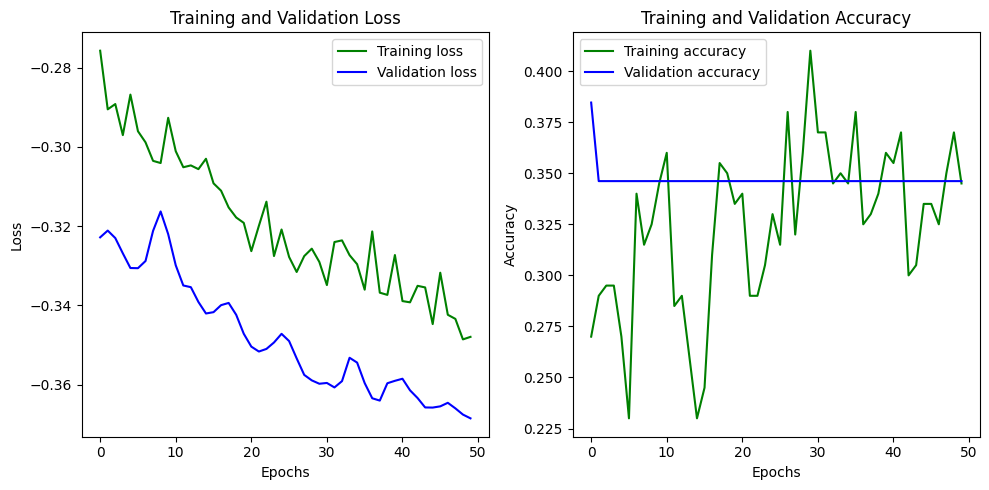

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install pydot

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

You must install pydot (`pip install pydot`) for `plot_model` to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_plot.png'

In [ ]:
name = '12-14'
model_filepath = './Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}')
model.save(model_filepath + f'/{name}.h5')

converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=./Kamel_Models/12-14.

<h2>Nour's Model

In [ ]:
import torch

# Load the entire model
model = torch.load('./Kamel_Models/model_74.weights.h5')


UnpicklingError: invalid load key, 'H'.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define your model architecture here
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(10,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

model2 = create_model()


In [ ]:
import tensorflow as tf

# Load the entire model
model = tf.keras.models.load_model('./Kamel_Models/model_74.weights.h5')


ValueError: No model config found in the file at ./Kamel_Models/model_74.weights.h5.